In [43]:
from helper.utils import (flowrule_template, get_full_topo_graph, 
                          hostid_to_mac, get_host, get_endpoint_info,
                          get_link_to_port)
import networkx as nx
import requests as rq
import json

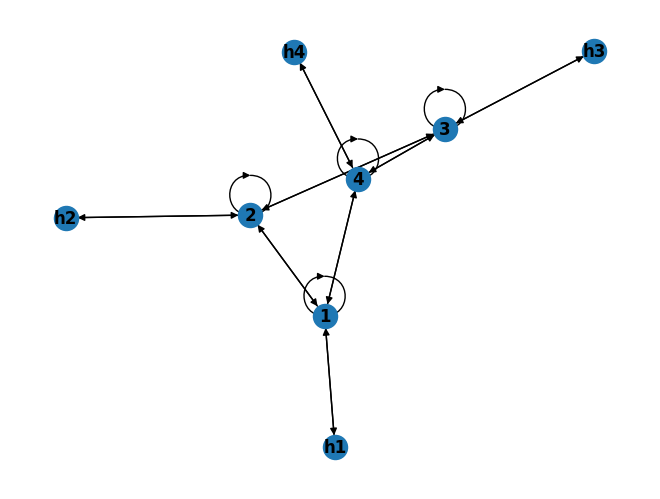

In [44]:
import matplotlib.pyplot as plt
_, graph = get_full_topo_graph()
# json to networkx object
# plot graph
nx.draw(graph, with_labels=True, font_weight='bold')
plt.show()

In [41]:
def create_flowrule_json(solutions, host_json, link_to_port):
    for solution in solutions['path']:
        path_dpid = solution['path_dpid']
        hostmac_src = hostid_to_mac(solution['src_host'])
        hostmac_dst = hostid_to_mac(solution['dst_host'])

        if (hostmac_src or hostmac_dst) == None or hostmac_src == hostmac_dst:
            raise (ValueError("invaild host mac"))
        
        _, src_endpoint_port = get_endpoint_info(hostmac_src, host_json)
        _, dst_endpoint_port = get_endpoint_info(hostmac_dst, host_json)
        
        dpid_flowport = {
            'eth_src': hostmac_src,
            'eth_dst': hostmac_dst,
            'dpid_path': [],
            'port_pair_path': []
        }
        
        for i in range(len(path_dpid)-1):
            # start
            if i == 0:
                in_port = src_endpoint_port
                out_port = link_to_port[path_dpid[i]][path_dpid[i+1]][0]
                print(f'start {i}')
                print(in_port, out_port)
                dpid_flowport['dpid_path'].append(path_dpid[i])
                dpid_flowport['port_pair_path'].append([in_port, out_port])
                            
            # inbetween
            if i > 0 and i <= len(path_dpid)-2:
                print(f'inbetween: {i}')
                # ra o dau nay thi vao o dau kia
                in_port = link_to_port[path_dpid[i-1]][path_dpid[i]][1]        
                out_port = link_to_port[path_dpid[i]][path_dpid[i+1]][0]
                dpid_flowport['dpid_path'].append(path_dpid[i])
                dpid_flowport['port_pair_path'].append([in_port, out_port])
                print(in_port, out_port)

            # finish
            if i >= len(path_dpid)-2:
                print(f'finish {i+1}')
                in_port = link_to_port[path_dpid[i]][path_dpid[i+1]][1]
                out_port = dst_endpoint_port
                # +1 for -2
                dpid_flowport['dpid_path'].append(path_dpid[i+1])
                dpid_flowport['port_pair_path'].append([in_port, out_port])
                print(in_port, out_port)

        # create bi-directional flowrule
    flowrules = []
    for dpid, port_pair in zip(dpid_flowport['dpid_path'], dpid_flowport['port_pair_path']):
        flowrules.append(flowrule_template(dpid, port_pair[0], port_pair[1], hostmac_src, hostmac_dst))
        flowrules.append(flowrule_template(dpid, port_pair[1], port_pair[0], hostmac_dst, hostmac_src))

    return flowrules

In [46]:
# nx.has_path(graph, 'h2', 'h3')
# nx.is_path(graph, [ 2, 3,])
_, graph = get_full_topo_graph()
path = nx.shortest_path(graph, 'h2', 'h3')
print(path)
solution = []
solution.append({
    "src_host": int(path[0].strip('h')),
    "dst_host": int(path[-1].strip('h')),
    "path_dpid": path[1:-1]
})
solutions = {'path': solution}
print(solutions)

# Fix in/out-port check in_port output
flowrules = create_flowrule_json(solutions, get_host(), get_link_to_port())
flowrules
for flowrule in flowrules:
    print(rq.post('http://0.0.0.0:8080/stats/flowentry/add', data=json.dumps(flowrule)).status_code)

['h2', 2, 3, 'h3']
{'path': [{'src_host': 2, 'dst_host': 3, 'path_dpid': [2, 3]}]}
start 0
1 3
finish 1
2 1
200
200
200
200


In [23]:
flows_1 = ['{"dpid": 1,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 1,"flags": 1,"match":{"in_port": 1,"dl_dst": "00:00:00:00:00:02","dl_src": "00:00:00:00:00:01"},"actions":[{"type":"OUTPUT","port": 2}]}',
'{"dpid": 1,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 1,"flags": 1,"match":{"in_port": 2,"dl_dst": "00:00:00:00:00:01","dl_src": "00:00:00:00:00:02"},"actions":[{"type":"OUTPUT","port": 1}]}',
'{"dpid": 4,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 1,"flags": 1,"match":{"in_port": 1,"dl_dst": "00:00:00:00:00:02","dl_src": "00:00:00:00:00:01"},"actions":[{"type":"OUTPUT","port": 2}]}',
'{"dpid": 4,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 1,"flags": 1,"match":{"in_port": 2,"dl_dst": "00:00:00:00:00:01","dl_src": "00:00:00:00:00:02"},"actions":[{"type":"OUTPUT","port": 1}]}',
'{"dpid": 2,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 1,"flags": 1,"match":{"in_port": 1,"dl_dst": "00:00:00:00:00:02","dl_src": "00:00:00:00:00:01"},"actions":[{"type":"OUTPUT","port": 3}]}',
'{"dpid": 2,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 1,"flags": 1,"match":{"in_port": 3,"dl_dst": "00:00:00:00:00:01","dl_src": "00:00:00:00:00:02"},"actions":[{"type":"OUTPUT","port": 1}]}']

flows_2 =  ['{"dpid": 1,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 2,"flags": 1,"match":{"in_port": 1,"dl_dst": "00:00:00:00:00:02","dl_src": "00:00:00:00:00:01"},"actions":[{"type":"OUTPUT","port": 3}]}',
'{"dpid": 1,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 2,"flags": 1,"match":{"in_port": 3,"dl_dst": "00:00:00:00:00:01","dl_src": "00:00:00:00:00:02"},"actions":[{"type":"OUTPUT","port": 1}]}',
'{"dpid": 3,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 2,"flags": 1,"match":{"in_port": 1,"dl_dst": "00:00:00:00:00:02","dl_src": "00:00:00:00:00:01"},"actions":[{"type":"OUTPUT","port": 2}]}',
'{"dpid": 3,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 2,"flags": 1,"match":{"in_port": 2,"dl_dst": "00:00:00:00:00:01","dl_src": "00:00:00:00:00:02"},"actions":[{"type":"OUTPUT","port": 1}]}',
'{"dpid": 2,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 2,"flags": 1,"match":{"in_port": 2,"dl_dst": "00:00:00:00:00:02","dl_src": "00:00:00:00:00:01"},"actions":[{"type":"OUTPUT","port": 3}]}',
'{"dpid": 2,"cookie": 1,"cookie_mask": 1,"table_id": 0,"idle_timeout": 3000,"hard_timeout": 3000,"priority": 2,"flags": 1,"match":{"in_port": 3,"dl_dst": "00:00:00:00:00:01","dl_src": "00:00:00:00:00:02"},"actions":[{"type":"OUTPUT","port": 2}]}']

for flow in flows_2:
    print(rq.post('http://0.0.0.0:8080/stats/flowentry/add', data=flow))

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
